In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import json

from config import Cfg as cfg

import mysql.connector

%matplotlib inline

## Race results

In [9]:
cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)

query = "SELECT * FROM results;"

# execute the query and assign it to a pandas dataframe
df_results = pd.read_sql(query, con=cnx)

cnx.close()

In [10]:
len(df_results.athlete.unique())

643055

## Races info

In [11]:
cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)

query = "SELECT * FROM races;"
# execute the query and assign it to a pandas dataframe
df_races = pd.read_sql(query, con=cnx)

cnx.close()

### Some processing on the datasets

In [12]:
# -----------
# -- RACES --
# -----------


# keep only active races
df_races = df_races.loc[df_races['info'].dropna().index]

# remove duplicates
df_races = df_races.loc[df_races.race != 'worldchampionship70.3m']

# remove worldchampionship
df_races = df_races.loc[df_races.race != 'worldchampionship70.3']
df_races = df_races.loc[df_races.race != 'worldchampionship']


# add Country codes
with open("./../data/geo-data/races_geo_info.json", 'r') as f:
    races_geo_info = json.loads(f.read())
             
df_races['country_code'] = None
for race in df_races.race.values:
    country_code = races_geo_info[race]
    df_races.loc[df_races.race == race, 'country_code'] = races_geo_info[race]['components']['ISO_3166-1_alpha-3']

# -----------
# -- RESULTS --
# -----------

# worldchampionship70.3 and worldchampionship70.3m are the same race
df_results.loc[df_results.race == "worldchampionship70.3m", 'race'] = 'worldchampionship70.3'

# keep only results of non discontinued races
df_results = df_results[df_results['race'].isin(df_races['race'])]

# extract gender from division
df_results['gender'] = df_results['division'].apply(lambda x: x[0])

# convert date to datetime
df_results['date'] = pd.to_datetime(df_results['date'])

# str to int
df_results['year'] = df_results['year'].apply(int)

# keep only results from before 2019
df_results = df_results.loc[df_results['year'] < 2019]

# discard pro athletes
df_results = df_results.loc[df_results.division.str.contains("PRO") == False]

# Add gender
df_results['gender'] = None
df_results.loc[df_results['division'].str.contains("M"), 'gender'] = "M"
df_results.loc[df_results['division'].str.contains("F"), 'gender'] = "F"

### what do we have left to work with?

In [13]:
print('-- Results dataset --')
print(f"  Number of single results: {len(df_results)}")
print(f"  Number of athletes: {len(df_results.athlete.unique())}")

print('-- Races dataset --')
print(f"  Number of active races: {len(df_races)}")

-- Results dataset --
  Number of single results: 1592599
  Number of athletes: 575481
-- Races dataset --
  Number of active races: 157


## Race count and unique race count per athlete

#### To prevent cold-start problem keep only people with at least 2 different races.

In [14]:
# total number of races per athlete
athletes_count_races = (df_results.groupby('athlete')['division']
     .size()
     .reset_index()
     .rename(columns={'division': 'n_races'})
)

# total number of different races per athlete
athletes_count_diff_races = (df_results
     .groupby(['athlete', 'race'])
     .size()
     .reset_index()
     .groupby('athlete')
     .size()
     .reset_index()
     .rename(columns={0: 'n_different_races'})
)

# merge the two so we can filter from that
athlete_habits = athletes_count_diff_races.merge(athletes_count_races, left_on="athlete", right_on="athlete", how="left")

# What we are filtering with
min_count_diff_races = 2
max_count_races = 100 # probably similar names

valid_athletes = athlete_habits.loc[(athlete_habits['n_different_races']>=min_count_diff_races) & (athlete_habits['n_races']<=max_count_races)]

# use this df to filter original results data
df_results_filtered = df_results.loc[df_results['athlete'].isin(valid_athletes['athlete'])]
df_results_filtered = df_results_filtered.merge(valid_athletes, left_on="athlete", right_on="athlete", how="left")

# Anonimize entrants
user_hash = {}

for i,user in enumerate(df_results_filtered.athlete.unique()):
    user_hash[user] = f'u{i}'
df_results_filtered.loc[:, 'athlete'] = df_results_filtered.athlete.map(lambda x: user_hash[x])

print("Number of different individuals:", len(valid_athletes))
print("Number of single results:", len(df_results_filtered))

Number of different individuals: 248360
Number of single results: 1190216


,id,athlete,division,rankdiv,rankgender,rankoverall,swim,t1,bike,t2,...,country,date,fulldata,score,swim_score,run_score,bike_score,gender,n_different_races,n_races
0,1518207,u0,M75-79,1,1073,1209,2440,678,11150,469,...,USA,2016-11-13,0,98.4,100.0,86.1,100.0,M,7,10
1,1518209,u1,M75-79,2,1141,1301,3539,679,13127,461,...,JPN,2016-11-13,0,97.1,77.2,100.0,90.7,M,7,12
2,1518210,u2,M65-69,1,181,202,1895,377,9944,243,...,AUS,2016-11-13,0,99.9,100.0,100.0,99.7,M,12,24
3,1518211,u3,M80-84,1,1281,1475,3135,784,13528,726,...,JPN,2016-11-13,0,100.0,100.0,100.0,100.0,M,5,15
4,1518213,u4,M55-59,1,134,152,2150,350,9711,282,...,ESP,2016-11-13,0,99.6,100.0,98.3,99.0,M,6,9


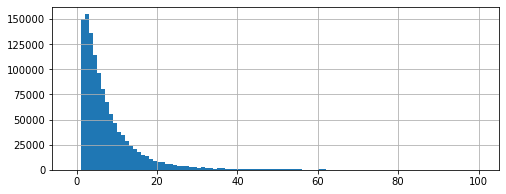

In [15]:
df_results_filtered['n_races'].hist(bins=np.arange(-0.99, 100.99, 1), figsize=(8, 3))
df_results_filtered.head(5)

A majority of athletes have < 20 races

# MODEL 1: the more you do a race, the more you implicitely like it

#### Count of each race for each entrants

In [16]:
results_data = (
    df_results_filtered
        .groupby(['athlete', 'race'])
        .size()
        .reset_index()
        .rename(columns={0: 'count'})
)

results_data.head()

,athlete,race,count
0,u0,brazil,1
1,u0,california70.3,1
2,u0,cozumel,2
3,u0,honu70.3,1
4,u0,loscabos,2


#### How many times the race has been done

In [17]:
race_popularity = (results_data
    .groupby(by = ['race'])['count']
    .sum()
    .reset_index()
    .rename(columns = {'count': 'total_count'})
)
race_popularity.head()

,race,total_count
0,Arizona70.3,5485
1,DunLaoghaire70.3,896
2,Florianopolis70.3,916
3,Haugesund70.3,2153
4,IMsubicbay,1152


In [18]:
print(race_popularity['total_count'].describe())
# print(race_popularity['total_count'].quantile(np.arange(.5, 1, .01)))

count      153.000000
mean      7779.189542
std       7610.135006
min        313.000000
25%       2375.000000
50%       4784.000000
75%      11083.000000
max      38737.000000
Name: total_count, dtype: float64


#### Add demographics info for users (if we want to filter later)

In [19]:
gender = (df_results_filtered
     .groupby(['athlete', 'gender'])
     .size()
     .reset_index()
     .rename(columns={0: 'n'})
     .pivot(index='athlete', columns='gender', values='n')
     .idxmax(axis=1)
     .rename('gender')
)

country = (df_results_filtered
     .groupby(['athlete', 'country'])
     .size()
     .reset_index()
     .rename(columns={0: 'n'})
     .pivot(index='athlete', columns='country', values='n')
     .idxmax(axis=1)
     .rename('country')
)

user_data_with_race_count = results_data.merge(race_popularity, left_on = 'race', right_on = 'race', how = 'left')
user_data_with_race_count = user_data_with_race_count.merge(gender, left_on = 'athlete', right_on = 'athlete', how = 'left')
user_data_with_race_count = user_data_with_race_count.merge(country, left_on = 'athlete', right_on = 'athlete', how = 'left')
user_data_with_race_count.head(10)

,athlete,race,count,total_count,gender,country
0,u0,brazil,1,12516,M,USA
1,u0,california70.3,1,29870,M,USA
2,u0,cozumel,2,16438,M,USA
3,u0,honu70.3,1,15449,M,USA
4,u0,loscabos,2,3532,M,USA
5,u0,mardelplata,1,1847,M,USA
6,u0,xiamen70.3,2,2185,M,USA
7,u1,cairns,1,7298,M,JPN
8,u1,canada70.3,1,2539,M,JPN
9,u1,honu70.3,3,15449,M,JPN


## --## -- Implemeting the Nearest Neighbor Model

#### Reshaping the Data

For K-Nearest Neighbors, we want the data to be in an m x n array, where m is the number of artists and n is the number of users. To reshape the dataframe, we’ll pivot the dataframe to the wide format with artists as rows and users as columns. Then we’ll fill the missing observations with 0s since we’re going to be performing linear algebra operations (calculating distances between vectors). Finally, we transform the values of the dataframe into a scipy sparse matrix for more efficient calculations.

In [20]:
from scipy.sparse import csr_matrix, save_npz

wide_race_data = user_data_with_race_count.pivot(index = 'race', columns = 'athlete', values = 'count').fillna(0)
wide_race_data_sparse = csr_matrix(wide_race_data.values)

save_npz('./../data/matrices/ironman_sparse_race_matrix.npz', wide_race_data_sparse)
save_npz('./../flask_app/nostrappdamus/model/data/races_sparse_matrix.npz', wide_race_data_sparse)

In [31]:
# import lat/lon data
races_locations = pd.read_csv("./../data/geo-data/races_lat_lon.csv")

# saving the races references for index
race_filter = df_races[['race', 'racename', 'region', 'country_code']]
race_filter['is_70.3'] = race_filter['race'].str.contains('70.3')

race_filter = race_filter.merge(races_locations, left_on = 'race', right_on = 'race', how = 'left')
race_filter = race_filter.set_index('race')


# make sure the filtering df has the same data/order than the wide_race_data
df_to_filter_races = pd.DataFrame(list(wide_race_data.index.map(lambda x: race_filter.loc[x].to_dict())), index=wide_race_data.index)


# save race data with races present in model
races_to_save = pd.read_csv("./../data/clean/races_info_features.csv", index_col='race')
races_to_save.loc[df_to_filter_races.index].to_csv("./../flask_app/nostrappdamus/model/data/races.csv")
# df_to_filter_races.to_csv("./../flask_app/nostrappdamus/model/data/races.csv")

/miniconda3/envs/data-science/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
# pd.read_csv("./../flask_app/nostrappdamus/model/data/races.csv", index_col='race')

#### Fitting the Model

Time to implement the model. We’ll initialize the NearestNeighbors class as model_knn and fit our sparse matrix to the instance. By specifying the metric = cosine, the model will measure similarity bectween artist vectors by using cosine similarity.

In [387]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(wide_race_data_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

#### Making Recommendations

And we’re finally ready to make some recommendations!

In [388]:
model_knn.kneighbors(wide_race_data.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 10)

(array([[4.22994972e-14, 6.10904360e-01, 8.31534267e-01, 8.53249237e-01,
         8.90684329e-01, 8.94114113e-01, 9.02577873e-01, 9.11143832e-01,
         9.11663773e-01, 9.12800854e-01]]),
 array([[ 22,  21, 125,   9,  30,  25,  81,  80, 150,   0]]))

In [381]:
query_index = np.random.choice(wide_race_data.shape[0])
distances, indices = model_knn.kneighbors(wide_race_data.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 10)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print(f'Recommendations for {wide_race_data.index[query_index]}:\n')
    else:
        print(f'{i}: {wide_race_data.index[indices.flatten()[i]]}, with distance of {distances.flatten()[i]}.')

Recommendations for boulder70.3:

1: boulder, with distance of 0.6109043595925852.
2: stgeorge70.3, with distance of 0.8315342671659637.
3: arizona, with distance of 0.853249236605025.
4: california70.3, with distance of 0.890684328651199.
5: buffalosprings70.3, with distance of 0.8941141131400768.
6: longhorn70.3, with distance of 0.9025778729498548.
7: lonestar70.3, with distance of 0.9111438324615692.
8: wisconsin, with distance of 0.9116637732258999.
9: Arizona70.3, with distance of 0.9128008544891082.


# MODEL 2: Binary racing. Either an entrants raced a race or not

Previously, we used the actual play counts as values in our artist vectors. Another approach would be convert each vector into a binary (1 or 0): either a user played the song or they did not. We can do this by applying the `sign` function in `numpy` to each column in the dataframe.

In [18]:
wide_race_data_zero_one = wide_race_data.apply(np.sign)
wide_race_data_zero_one_sparse = csr_matrix(wide_race_data_zero_one.values)

save_npz('./../data/matrices/ironman_sparse_race_matrix_binary.npz', wide_race_data_zero_one_sparse)

In [19]:
model_knn_binary = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn_binary.fit(wide_race_data_zero_one_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

## Let’s make a quick comparison. Which recommendations look better?

In [20]:
distances, indices = model_knn_binary.kneighbors(wide_race_data_zero_one.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 10)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print(f'Recommendations for {wide_race_data_zero_one.index[query_index]}:\n')
    else:
        print(f'{i}: {wide_race_data_zero_one.index[indices.flatten()[i]]}, with distance of {distances.flatten()[i]}.')

Recommendations for muskoka70.3:

1: monttremblant70.3, with distance of 0.7133333841301872.
2: monttremblant, with distance of 0.725983388293276.
3: syracuse70.3, with distance of 0.8517114185320253.
4: lakeplacid, with distance of 0.8838580845284014.
5: lakeplacid70.3, with distance of 0.8903579454103698.
6: canada, with distance of 0.9051123273815019.
7: steelhead70.3, with distance of 0.9126632509098189.
8: calgary70.3, with distance of 0.9345573138181335.
9: eagleman70.3, with distance of 0.9386132421953461.


The binary data representation recommendations look qualitatively similar.

Again, it’s not obvious which method is better. Since ultimately it’s the users’s future actions that indicate which recommender system is better, it’s a perfect candidate for A/B Testing. For now, I’ll stick with the non-binary data representation model.

## Implement pre-filtering

In [21]:
race_filter = df_races[['race', 'region', 'country_code']]
race_filter['is_70.3'] = race_filter['race'].str.contains('70.3')
race_filter = race_filter.set_index('race')
race_filter.head()

# make sure the filtering df has the same data/order than the wide_race_data
df_to_filter_races = pd.DataFrame(list(wide_race_data.index.map(lambda x: race_filter.loc[x].to_dict())), index=wide_race_data.index)

/miniconda3/envs/data-science/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
df_to_filter_races.shape, race_filter.shape

((153, 3), (157, 3))

In [23]:
def get_filtered_races(filterBy, value, df=df_to_filter_races, returnIndices=False):
    if not filterBy:
        selection = df
    else:
        selection = df.loc[df[filterBy] == value]
    if returnIndices:
        return selection.index.map(lambda x: df.index.get_loc(x)).tolist()
    else:
        return selection.index.values

In [24]:
def get_prediction(similarTo, n=10, filterBy=False, value=False):
    if filterBy:
        selection_races = get_filtered_races(filterBy, value, df=df_to_filter_races)
        data = user_data_with_race_count.loc[user_data_with_race_count['race'].isin(selection_races)]
    else:
        data = user_data_with_race_count
    wide_data = data.pivot(index = 'race', columns = 'athlete', values = 'count')
    
    if similarTo not in wide_data.index:
        row_to_add = (user_data_with_race_count
                          .loc[user_data_with_race_count['race'] == similarTo]
                          .pivot(index='race', columns='athlete', values='count')
                     )
        # add row back if it was filtered out
        wide_data = pd.concat([wide_data, row_to_add], sort=False)
    wide_data.fillna(0, inplace=True)
    data_sparse = csr_matrix(wide_data.values)
        
    model_nn_binary = NearestNeighbors(metric='cosine', algorithm='brute')
    model_nn_binary.fit(data_sparse)
    query_index = np.where(wide_data.index == similarTo)[0][0]
    distances, indices = model_nn_binary.kneighbors(wide_data.iloc[query_index, :].values.reshape(1, -1), n_neighbors = n+1)
    distances = distances.flatten()
    indices = indices.flatten()
    return [(wide_data.index[indices[i]], distances[i]) for i in range(1, len(distances))]

In [25]:
get_prediction('Arizona70.3')

[('arizona', 0.7861915846702664),
 ('california70.3', 0.8516627809813649),
 ('stgeorge70.3', 0.8694722935189386),
 ('indianwellslaquinta70.3', 0.8920661774114591),
 ('santarosa70.3', 0.9032628733428057),
 ('boulder70.3', 0.9128008544891082),
 ('superfrog70.3', 0.923165281195798),
 ('coeurdalene70.3', 0.9243375258295179),
 ('santacruz70.3', 0.9303157440175995),
 ('boulder', 0.9314105332245298)]

In [26]:
get_prediction('Arizona70.3', filterBy='is_70.3', value=False)

[('arizona', 0.7861915846702664),
 ('boulder', 0.9314105332245298),
 ('santarosa', 0.9458733001072461),
 ('texas', 0.9574168738453601),
 ('st.george', 0.9622583796527981),
 ('canada', 0.9629124576963345),
 ('florida', 0.9687432184274619),
 ('louisville', 0.9691280053694747),
 ('wisconsin', 0.971610079426734),
 ('chattanooga', 0.9731856992862584)]

## Faster prediction by pre-computing the matrix and fitting the model prior and filtering on the full results data

In [27]:
# precompute similarity matrix and do filtering as post-process
wide_race_data = user_data_with_race_count.pivot(index = 'race', columns = 'athlete', values = 'count').fillna(0)
wide_race_data_sparse = csr_matrix(wide_race_data.values)

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(wide_race_data_sparse)

# import pickle
# # save the model to disk
# filename = './../flask_app/nostrappdamus/model/data/knn.sav'
# pickle.dump(model_knn, open(filename, 'wb'))
 
# # some time later...
 
# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)

# make sure the filtering df has the same data/order than the wide_race_data
df_to_filter_races = pd.DataFrame(list(wide_race_data.index.map(lambda x: race_filter.loc[x].to_dict())), index=wide_race_data.index)

def get_prediction_fast(similarTo, n=10, filterBy=False, value=False):
    query_index = np.where(wide_race_data.index == similarTo)[0][0]
    total_n = wide_race_data.shape[0]
    distances, indices = model_knn.kneighbors(wide_race_data.iloc[query_index].values.reshape(1, -1), n_neighbors = total_n)
    distances = distances.flatten()
    indices = indices.flatten()
    
    if filterBy:
        selection_idx = get_filtered_races(filterBy, value, df=df_to_filter_races, returnIndices=False)
        n = n if n<len(selection_idx) else len(selection_idx)
        out_distances = []
        out_races = []
        
        for indice,distance in zip(indices, distances):
            race = wide_race_data.index[indice]
            if ((race in selection_idx) and (race != similarTo)):
                out_races.append(race)
                out_distances.append(distance)
                if len(out_distances) >=n :
                    break
    else:
        out_races = wide_race_data.index[indices[1:n+1]] #remove the race itself
        out_distances = distances[1:n+1] #remove the race itself
    
    out_df = df_to_filter_races.loc[out_races]
    out_df['similarity'] = out_distances
        
    return out_df#[(race, distance) for race,distance in zip(out_races, out_distances)]

In [28]:
# df_to_filter_races.region.to_dict()

In [117]:
get_prediction_fast('monterrey70.3', filterBy='is_70.3', value=True)

,country_code,is_70.3,region,similarity
race,,,,
cancun70.3,MEX,True,North America,0.662201
campeche70.3,MEX,True,North America,0.727810
loscabos70.3,MEX,True,North America,0.796758
longhorn70.3,USA,True,,0.911754
miami70.3,USA,True,,0.920974
costarica70.3,CRI,True,South America,0.924642
lonestar70.3,USA,True,North America,0.940391
cartagena70.3,COL,True,South America,0.944718
sanjuan70.3,PRI,True,North America,0.947989


In [30]:
get_prediction('monterrey70.3', filterBy='is_70.3', value=True)

[('cancun70.3', 0.6622009185561006),
 ('campeche70.3', 0.7278102963493052),
 ('loscabos70.3', 0.7967583283520696),
 ('longhorn70.3', 0.9117541800594359),
 ('miami70.3', 0.9209735305829925),
 ('costarica70.3', 0.9246421260789416),
 ('lonestar70.3', 0.9403913226062405),
 ('cartagena70.3', 0.9447176228039565),
 ('sanjuan70.3', 0.9479892218873789),
 ('buffalosprings70.3', 0.9588267271987684)]

# Evaluation

Evaluation is important for machine learning projects, because it allows to compare objectivelly different algorithms and hyperparameter choices for models.
One key aspect of evaluation is to ensure that the trained model generalizes for data it was not trained on, using Cross-validation techniques. We are using here a simple cross-validation approach named **holdout**, in which a random data sample (30% in this case) are kept aside in the training process, and exclusively used for evaluation. All evaluation metrics reported here are computed using the test set.

Ps. A more robust evaluation approach could be to split train and test sets by a reference date, where the train set is composed by all interactions before that date, and the test set are interactions after that date. For the sake of simplicity, we chose the first random approach for this notebook, but you may want to try the second approach to better simulate how the recsys would perform in production predicting "future" users interactions.

In [40]:
from utils.average_precision import apk, mapk

In [72]:
from sklearn.model_selection import train_test_split

results_df = results_data.copy()
results_train_df, results_test_df = train_test_split(results_df,
                                                     stratify=results_data['athlete'], 
                                                     test_size=0.30,
                                                     random_state=42)

print('# results in Train set: %d' % len(results_train_df))
print('# interactions on Test set: %d' % len(results_test_df))

# results in Train set: 603290
# interactions on Test set: 258553


In Recommender Systems, there are a set metrics commonly used for evaluation. We chose to work with **Top-N accuracy metrics**, which evaluates the accuracy of the top recommendations provided to a user, comparing to the items the user has actually interacted in test set.

**Note:** 
For what is to follow, we naively assume that if an individual has not done a race then it means the race is not relevant to him/her, which might not be true, as the individual may simply not be aware of the race or not had time to do it yet. But let's keep this assumption.

This evaluation method works as follows:
   * For each user
   * For each result in test set (item the user has interacted with)
   * Sample 100 other items the user has never interacted.
   * Ask the recommender model to produce a ranked list of recommended races, from a set composed of one race raced by the individual and 100 races not raced ("non-relevant!)
   * Compute the Top-N accuracy metrics for this individual and interacted race from the recommendations ranked list
   * Aggregate the global Top-N accuracy metrics
   
The Top-N accuracy metric choosen is **Recall@N** which evaluates whether the interacted race is among the top N races (hit) in the ranked list of 101 recommendations for an individual.

**None:**
Other popular ranking metrics are **NDCG@N** and **MAP@N**, whose score calculation takes into account the position of the relevant item in the ranked list (max. value if relevant item is in the first position). (see http://fastml.com/evaluating-recommender-systems/)

In [73]:
#Indexing by athleteID to speed up the searches during evaluation
results_df = results_df.set_index('athlete')
results_train_df = results_train_df.set_index('athlete')
results_test_df = results_test_df.set_index('athlete')

In [152]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_RACES = 100

import random

res = {}

class ModelEvaluator:
    
    @staticmethod
    def get_races_for(athlete_id, results_df=results_df):
        '''Get all the races done by an athlete in the full dataset'''
        # Get the athltes's results and merge in the movie information.
        interacted_races = results_df.loc[athlete_id]['race']
        return set(interacted_races if type(interacted_races) == pd.Series else [interacted_races])
        
    def get_not_raced_sample(self, athlete_id, sample_size, seed=42, results_df=results_df):
        '''Get a sample of races not done by athlete'''
        # all races done by athlete
        all_athlete_races = self.get_races_for(athlete_id, results_df)
        # all races present in dataset
        all_races = set(results_df['race'])
        # races not done by athlete
        not_raced = all_races - all_athlete_races
        random.seed(seed)
        not_raced_sample = random.sample(not_raced, sample_size)
        return set(not_raced_sample)

    def _verify_hit_top_n(self, race_id, recommended_races, topn): 
        '''Check if race is in topn of recommended races provided'''
        try:
            index = next(i for i, c in enumerate(recommended_races) if c == race_id)
        except:
            index = -1
        hit = int(index in range(0, topn))
        return hit, index

    def evaluate_model_for_athlete(self, model, athlete_id, test_set=results_test_df, train_set=results_train_df):
        '''Evaluate the recommendations provided by the model for the athlete'''
        # Getting the list of races presents in test set for athlete
        raced_in_testset = test_set.loc[athlete_id]
        if type(raced_in_testset['race']) == pd.Series:
            raced_in_testset = set(raced_in_testset['race'])
        else:
            raced_in_testset = set([raced_in_testset['race']])  
        raced_in_testset_count = len(raced_in_testset) 

        # Getting a ranked recommendation list from a model for a given user
        recommended_races = model.recommend_races(athlete_id, 
                                                  items_to_ignore=self.get_races_for(athlete_id, train_set), 
                                                  topn=200)

        hits_at_5_count = 0
        hits_at_10_count = 0
        # For each race the athlete has done in test set
        for race_id in raced_in_testset:
            # Getting a random sample (100) races the athlete has not raced
            # (to represent races that are assumed to be no relevant to the athlete)
            not_raced_sample = self.get_not_raced_sample(athlete_id, sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_RACES, 
                                                         seed=model.items_df.index.get_loc(race_id)%(2**32))

            # Combining the current interacted item with the 100 random items
            to_keep = not_raced_sample.union(set([race_id]))

            # Filtering only recommendations that are either the interacted race or from the random sample of 100 non-interacted races
            valid_recs_df = recommended_races[recommended_races.index.isin(to_keep)]                    
            valid_recs = valid_recs_df.index.values
            # Verifying if the current race is among the Top-N recommended races
            hit_at_5, index_at_5 = self._verify_hit_top_n(race_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(race_id, valid_recs, 10)
            hits_at_10_count += hit_at_10
            
        # Recall is the rate of the interacted races that are ranked among the Top-N recommended races, 
        # when mixed with a set of non-relevant races
        recall_at_5 = hits_at_5_count / float(raced_in_testset_count)
        recall_at_10 = hits_at_10_count / float(raced_in_testset_count)

        athlete_metrics = {'hits@5_count':hits_at_5_count, 
                           'hits@10_count':hits_at_10_count, 
                           'raced_count': raced_in_testset_count,
                           'recall@5': recall_at_5,
                           'recall@10': recall_at_10}
        return athlete_metrics

    def evaluate_model(self, model, limit=False, test_set=results_test_df, train_set=results_train_df):
        # print('Running evaluation for athlete')
        all_athletes_metrics = []
        limit = len(test_set.index.unique()) if not limit else limit
        for idx, athlete_id in enumerate(list(test_set.index.unique().values)[:limit]):
            athlete_metrics = self.evaluate_model_for_athlete(model, athlete_id)  
            athlete_metrics['athlete'] = athlete_id
            all_athletes_metrics.append(athlete_metrics)

        detailed_results = pd.DataFrame(all_athletes_metrics).sort_values('raced_count', ascending=False)
        
        global_recall_at_5 = detailed_results['hits@5_count'].sum() / float(detailed_results['raced_count'].sum())
        global_recall_at_10 = detailed_results['hits@10_count'].sum() / float(detailed_results['raced_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results

    
model_evaluator = ModelEvaluator() 

## Popularity model
A common (and usually hard-to-beat) baseline approach is the Popularity model. This model is not actually personalized - it simply recommends to a user the most popular items that the user has not previously consumed. As the popularity accounts for the "wisdom of the crowds", it usually provides good recommendations, generally interesting for most people.
Ps. The main objective of a recommender system is to leverage the long-tail items to the users with very specific interests, which goes far beyond this simple technique.

In [336]:
#Computes the most popular races
races_popularity_df = results_train_df.groupby('race')['count'].sum().sort_values(ascending=False).reset_index()
races_popularity_df.index = races_popularity_df['race']
races_popularity_df.head(10)

,race,count
race,,
florida,florida,27247
lakeplacid,lakeplacid,23131
arizona,arizona,22118
california70.3,california70.3,21188
wisconsin,wisconsin,21079
austria,austria,18761
louisville,louisville,18671
florida70.3,florida70.3,17016
canada,canada,16493


In [337]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_races(self, athlete_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['race'].isin(items_to_ignore)] \
                               .sort_values('count', ascending = False) \
                               .head(topn)
        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'race', 
                                                          right_on = 'race')[['count', 'race']]


        return recommendations_df
    
popularity_model = PopularityRecommender(races_popularity_df, race_filter)

print(f'Evaluating {popularity_model.get_model_name()}  model...')
popularity_global_metrics, popularity_detailed_results = model_evaluator.evaluate_model(popularity_model, limit=1000)
print(f'\nGlobal metrics:\n{popularity_global_metrics}')
popularity_detailed_results.head(15)

Evaluating Popularity  model...

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.22838709677419355, 'recall@10': 0.3496774193548387}


,athlete,hits@10_count,hits@5_count,raced_count,recall@10,recall@5
235,u31045,5,3,9,0.555556,0.333333
2,u19652,5,5,8,0.625000,0.625000
876,u55739,1,1,7,0.142857,0.142857
257,u2457,2,2,7,0.285714,0.285714
601,u7052,3,1,7,0.428571,0.142857
724,u39058,5,3,7,0.714286,0.428571
846,u13796,3,3,7,0.428571,0.428571
652,u20214,2,1,7,0.285714,0.142857
247,u31101,3,2,6,0.500000,0.333333
49,u113430,1,1,6,0.166667,0.166667


## Collaborative filtering: KNN on sparse matrix

In [338]:
user_data_train = results_train_df.reset_index().merge(races_popularity_df.rename(columns={'count': 'total_count'}).drop('race', axis=1), left_on = 'race', right_on = 'race', how = 'left')
user_data_train = user_data_train.merge(gender, left_on = 'athlete', right_on = 'athlete', how = 'left')
user_data_train = user_data_train.merge(country, left_on = 'athlete', right_on = 'athlete', how = 'left')
user_data_train.head(10)

,athlete,race,count,total_count,gender,country
0,u99670,newzealand,4,9373,M,NZL
1,u201110,lakeplacid,1,23131,M,USA
2,u53564,barcelona,1,7537,M,ESP
3,u21016,florida70.3,1,17016,F,USA
4,u95734,california70.3,1,21188,M,MEX
5,u36274,vichy,1,3399,M,FRA
6,u77563,syracuse70.3,1,7827,M,FRA
7,u76087,bahrain70.3,1,1628,M,KAZ
8,u49600,mallorca70.3,2,12384,M,SWE
9,u68307,luxembourg70.3,1,4887,F,ZAF


In [339]:
# precompute similarity matrix and do filtering as post-process
wide_race_data_train = user_data_train.pivot(index = 'race', columns = 'athlete', values = 'count').fillna(0)
wide_race_data_train_sparse = csr_matrix(wide_race_data_train.values)

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(wide_race_data_train_sparse)
 
# make sure the filtering df has the same data/order than the wide_race_data
df_to_filter_races = pd.DataFrame(list(wide_race_data_train.index.map(lambda x: race_filter.loc[x].to_dict())), index=wide_race_data_train.index)

def get_prediction_fast(similarTo, n=10, filterBy=False, value=False):
    query_index = np.where(wide_race_data_train.index == similarTo)[0][0]
    total_n = wide_race_data_train.shape[0]
    distances, indices = model_knn.kneighbors(wide_race_data_train.iloc[query_index].values.reshape(1, -1), n_neighbors = total_n)
    distances = distances.flatten()
    indices = indices.flatten()
    
    if filterBy:
        selection_idx = get_filtered_races(filterBy, value, df=df_to_filter_races, returnIndices=False)
        n = n if n<len(selection_idx) else len(selection_idx)
        out_distances = []
        out_races = []
        
        for indice,distance in zip(indices, distances):
            race = wide_race_data_train.index[indice]
            if ((race in selection_idx) and (race != similarTo)):
                out_races.append(race)
                out_distances.append(distance)
                if len(out_distances) >=n :
                    break
    else:
        out_races = wide_race_data_train.index[indices[1:n+1]] #remove the race itself
        out_distances = distances[1:n+1] #remove the race itself
    
    out_df = df_to_filter_races.loc[out_races]
    out_df['similarity'] = out_distances
        
    return out_df#[(race, distance) for race,distance in zip(out_races, out_distances)]

In [340]:
class CF_sparse:
    
    MODEL_NAME = 'Collaborative-Based (sparse)'
    
    def __init__(self, items_df=None):
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_races(self, athlete_id, items_to_ignore=[], topn=10):
        recommended = get_prediction_fast(list(items_to_ignore)[0], topn)
        # filter out the races that have to be ignored
        to_exclude = recommended.index.isin(items_to_ignore)
        recommendations_df = recommended[~to_exclude]

        return recommendations_df.head(topn)
    
cf_sparse = CF_sparse(race_filter)

print(f'Evaluating {cf_sparse.get_model_name()}  model...')
cf_sparse_global_metrics, cf_sparse_detailed_results = model_evaluator.evaluate_model(cf_sparse, limit=1000)
print(f'\nGlobal metrics:\n{cf_sparse_global_metrics}')
cf_sparse_detailed_results.head(15)

Evaluating Collaborative-Based (sparse)  model...

Global metrics:
{'modelName': 'Collaborative-Based (sparse)', 'recall@5': 0.41096774193548385, 'recall@10': 0.5754838709677419}


,athlete,hits@10_count,hits@5_count,raced_count,recall@10,recall@5
235,u31045,0,0,9,0.000000,0.000000
2,u19652,6,5,8,0.750000,0.625000
876,u55739,0,0,7,0.000000,0.000000
257,u2457,0,0,7,0.000000,0.000000
601,u7052,3,1,7,0.428571,0.142857
724,u39058,0,0,7,0.000000,0.000000
846,u13796,3,1,7,0.428571,0.142857
652,u20214,1,1,7,0.142857,0.142857
247,u31101,2,2,6,0.333333,0.333333
49,u113430,0,0,6,0.000000,0.000000


## Collaborative-based filtering (SVD + KNN)

In [341]:
from sklearn.decomposition import TruncatedSVD
import pickle

X = wide_race_data_train.values

n_components = 25

SVD = TruncatedSVD(n_components=n_components, random_state=17)
matrix = SVD.fit_transform(X)
matrix.shape

# # save matrix
# np.save(f'./../flask_app/nostrappdamus/model/data/races_condensed_matrix_svd-{n_components}.npy', matrix)


model_knn_svd = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn_svd.fit(matrix)

# make sure the filtering df has the same data/order than the wide_race_data
df_to_filter_races = pd.DataFrame(list(wide_race_data_train.index.map(lambda x: race_filter.loc[x].to_dict())), index=wide_race_data_train.index)

def get_prediction_svd_fast(similarTo, n=10, filterBy=False, value=False):
    query_index = np.where(wide_race_data_train.index == similarTo)[0][0]
    total_n = wide_race_data_train.shape[0]
    distances, indices = model_knn_svd.kneighbors(matrix[query_index].reshape(1, -1), n_neighbors = total_n)
    distances = distances.flatten()
    indices = indices.flatten()
    
    if filterBy:
        selection_idx = get_filtered_races(filterBy, value, df=df_to_filter_races, returnIndices=False)
        n = n if n<len(selection_idx) else len(selection_idx)
        out_distances = []
        out_races = []
        
        for indice,distance in zip(indices, distances):
            race = wide_race_data_train.index[indice]
            if ((race in selection_idx) and (race != similarTo)):
                out_races.append(race)
                out_distances.append(distance)
                if len(out_distances) >=n :
                    break
    else:
        out_races = wide_race_data_train.index[indices[1:n+1]] #remove the race itself
        out_distances = distances[1:n+1] #remove the race itself
    
    out_df = df_to_filter_races.loc[out_races]
    out_df['similarity'] = out_distances
        
    return out_df

In [342]:
class CF_SVD:
    
    MODEL_NAME = 'Collaborative-Based (SVD)'
    
    def __init__(self, items_df=None):
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_races(self, athlete_id, items_to_ignore=[], topn=10, use=1):
        recommended = get_prediction_svd_fast(list(items_to_ignore)[0], topn)
        # filter out the races that have to be ignored
        to_exclude = recommended.index.isin(items_to_ignore)
        recommendations_df = recommended[~to_exclude]

        return recommendations_df.head(topn)
    
cf_svd = CF_SVD(race_filter)

print(f'Evaluating {cf_svd.get_model_name()}  model...')
cf_svd_global_metrics, cf_svd_detailed_results = model_evaluator.evaluate_model(cf_svd, limit=1000)
print(f'\nGlobal metrics:\n{cf_svd_global_metrics}')
cf_svd_detailed_results.head(15)

Evaluating Collaborative-Based (SVD)  model...

Global metrics:
{'modelName': 'Collaborative-Based (SVD)', 'recall@5': 0.24258064516129033, 'recall@10': 0.35096774193548386}


,athlete,hits@10_count,hits@5_count,raced_count,recall@10,recall@5
235,u31045,0,0,9,0.000000,0.000000
2,u19652,0,0,8,0.000000,0.000000
876,u55739,0,0,7,0.000000,0.000000
257,u2457,0,0,7,0.000000,0.000000
601,u7052,1,1,7,0.142857,0.142857
724,u39058,0,0,7,0.000000,0.000000
846,u13796,0,0,7,0.000000,0.000000
652,u20214,1,1,7,0.142857,0.142857
247,u31101,2,1,6,0.333333,0.166667
49,u113430,0,0,6,0.000000,0.000000


## Compare results

In [343]:
pd.DataFrame({
    "popularity": popularity_detailed_results.mean(), 
    "CF_sparse": cf_sparse_detailed_results.mean(),
    "CF_SVD": cf_svd_detailed_results.mean()
})

,popularity,CF_sparse,CF_SVD
hits@10_count,0.542000,0.892000,0.544000
hits@5_count,0.354000,0.637000,0.376000
raced_count,1.550000,1.550000,1.550000
recall@10,0.329966,0.644050,0.412602
recall@5,0.217180,0.478587,0.299786


In [344]:
print(popularity_global_metrics)
print(cf_sparse_global_metrics)
print(cf_svd_global_metrics)

{'modelName': 'Popularity', 'recall@5': 0.22838709677419355, 'recall@10': 0.3496774193548387}
{'modelName': 'Collaborative-Based (sparse)', 'recall@5': 0.41096774193548385, 'recall@10': 0.5754838709677419}
{'modelName': 'Collaborative-Based (SVD)', 'recall@5': 0.24258064516129033, 'recall@10': 0.35096774193548386}


## Increasing knowledge about a user

In [345]:
class CF_SVD:
    
    MODEL_NAME = 'Collaborative-Based (SVD)'
    
    def __init__(self, items_df=None, n=1):
        self.items_df = items_df
        self.n_knowledge = n
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_races(self, athlete_id, items_to_ignore=[], topn=10):
        recommended = []
        n_use = self.n_knowledge if self.n_knowledge < len(items_to_ignore) else len(items_to_ignore)
        for i in range(n_use):
            race = list(items_to_ignore)[i]
            rec = get_prediction_svd_fast(race, topn)
            recommended.append(rec)
            
        
        recommended = pd.concat(recommended).sort_values('similarity')
        # filter out the races that have to be ignored
        to_exclude = recommended.index.isin(items_to_ignore)
        recommendations_df = recommended[~to_exclude]

        return recommendations_df.head(topn)
    

global_cf_svd_increasing = {}

for i in range(1, 11):
    cf_svd = CF_SVD(race_filter, i)
    print(f'Evaluating {cf_svd.get_model_name()}  model with knowledge {cf_svd.n_knowledge}')
    global_metrics, detailed_results = model_evaluator.evaluate_model(cf_svd, limit=100)
    print(f'\nGlobal metrics:\n{global_metrics}')
    global_cf_svd_increasing[i] = global_metrics

Evaluating Collaborative-Based (SVD)  model with knowledge 1

Global metrics:
{'modelName': 'Collaborative-Based (SVD)', 'recall@5': 0.29411764705882354, 'recall@10': 0.45098039215686275}
Evaluating Collaborative-Based (SVD)  model with knowledge 2

Global metrics:
{'modelName': 'Collaborative-Based (SVD)', 'recall@5': 0.29411764705882354, 'recall@10': 0.4117647058823529}
Evaluating Collaborative-Based (SVD)  model with knowledge 3

Global metrics:
{'modelName': 'Collaborative-Based (SVD)', 'recall@5': 0.28104575163398693, 'recall@10': 0.41830065359477125}
Evaluating Collaborative-Based (SVD)  model with knowledge 4


KeyboardInterrupt: 

# Matrix factorization with Scipy

Latent factor models compress user-item matrix into a low-dimensional representation in terms of latent factors. One advantage of using this approach is that instead of having a high dimensional matrix containing abundant number of missing values we will be dealing with a much smaller matrix in lower-dimensional space.
A reduced presentation could be utilized for either user-based or item-based neighborhood algorithms that are presented in the previous section. There are several advantages with this paradigm. It handles the sparsity of the original matrix better than memory based ones. Also comparing similarity on the resulting matrix is much more scalable especially in dealing with large sparse datasets.

Here we a use popular latent factor model named **Singular Value Decomposition (SVD)**. There are other matrix factorization frameworks more specific to CF you might try, like surprise, mrec or python-recsys. We chose a SciPy implemenation of SVD.

An important decision is the number of factors to factor the user-item matrix. The higher the number of factors, the more precise is the factorization in the original matrix reconstructions. Therefore, if the model is allowed to memorize too much details of the original matrix, it may not generalize well for data it was not trained on. Reducing the number of factors increases the model generalization.

In [ ]:
# users_items_pivot_matrix_df = wide_race_data.transpose()

# users_items_pivot_matrix = users_items_pivot_matrix_df.as_matrix()
# users_items_pivot_matrix[:10]

In [346]:
users_items_pivot_train = wide_race_data_train.transpose()

users_items_pivot_train_matrix = users_items_pivot_train.as_matrix()
users_items_pivot_train_matrix[:10]

/miniconda3/envs/data-science/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[0., 0., 0., ..., 0., 0., 2.],
       [0., 0., 0., ..., 0., 0., 3.],
       [0., 0., 0., ..., 0., 0., 2.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [347]:
users_ids = list(users_items_pivot_train.index)
users_ids[:10]

['u0',
 'u1',
 'u10',
 'u100',
 'u1000',
 'u10000',
 'u100000',
 'u100001',
 'u100002',
 'u100003']

In [348]:
from scipy.sparse.linalg import svds

#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 25
#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_train_matrix, k = NUMBER_OF_FACTORS_MF)

In [349]:
U.shape

(248360, 25)

In [350]:
Vt.shape

(25, 153)

In [351]:
sigma = np.diag(sigma)
sigma.shape

(25, 25)

After the factorization, we try to to reconstruct the original matrix by multiplying its factors. The resulting matrix is not sparse any more. It was generated predictions for items the user have not yet interaction, which we will exploit for recommendations.

In [352]:
all_user_predicted_ratings_train = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings_train

array([[ 2.97599177e-02,  6.67707966e-04,  9.09381966e-03, ...,
         1.80214702e-02, -5.36627565e-03,  3.83074273e-03],
       [ 7.06662223e-04,  7.81916558e-04,  1.55545833e-04, ...,
        -1.16907878e-03,  4.38545845e-04,  1.77587834e-03],
       [ 2.42237333e-04,  3.62847946e-04,  3.92413491e-05, ...,
        -4.98615542e-04,  3.06510418e-04,  7.48145483e-04],
       ...,
       [ 3.91088745e-04,  5.76963491e-03, -5.50732481e-05, ...,
         1.44315428e-03,  3.37850780e-03,  1.12886071e-02],
       [ 1.36877544e-03,  3.01023867e-03, -4.99529186e-04, ...,
         9.21393353e-03,  2.84348007e-03,  5.98366707e-03],
       [ 1.91586804e-03,  2.59779617e-03,  1.37930461e-04, ...,
        -1.30551645e-03,  2.26010078e-03,  6.39734122e-03]])

In [353]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_train = pd.DataFrame(all_user_predicted_ratings_train, columns = users_items_pivot_train.columns, index=users_ids).transpose()
cf_preds_train.head(10)

,u0,u1,u10,u100,u1000,u10000,u100000,u100001,u100002,u100003,...,u99990,u99991,u99992,u99993,u99994,u99995,u99996,u99997,u99998,u99999
race,,,,,,,,,,,,,,,,,,,,,
Arizona70.3,0.029760,0.000707,0.000242,-0.002548,0.000225,0.001139,0.001011,0.003832,0.000081,0.001576,...,0.000337,0.000058,0.001142,0.003636,-0.000579,0.004686,0.000798,0.000391,0.001369,0.001916
DunLaoghaire70.3,0.000668,0.000782,0.000363,0.002010,0.000986,0.000178,0.006474,0.005196,0.000225,0.000730,...,0.002158,0.000098,0.000219,0.000631,0.001998,0.001476,0.000612,0.005770,0.003010,0.002598
Florianopolis70.3,0.009094,0.000156,0.000039,-0.000586,-0.000169,-0.000065,0.000614,0.000276,0.000098,0.000272,...,0.000205,0.000008,0.000003,0.006265,-0.000352,-0.000089,0.004704,-0.000055,-0.000500,0.000138
Haugesund70.3,0.001121,0.000275,0.000196,0.002166,0.002567,0.000047,-0.000205,-0.000514,0.000735,0.001831,...,-0.000068,0.000405,0.000349,0.000555,0.002158,0.003750,0.001408,0.001347,0.000497,-0.000257
IMsubicbay,0.003350,0.001347,0.000570,0.000857,0.000742,0.000051,0.012362,0.011073,0.000069,0.000321,...,0.004121,0.000011,0.000040,0.000346,0.000310,0.002978,0.000474,0.008695,0.004062,0.005536
Maastricht,0.004035,0.001744,0.000659,0.007381,0.020196,0.000098,0.006019,0.002837,0.000899,0.004352,...,0.002006,0.000397,0.000448,0.000192,0.015580,0.009056,0.003114,0.007400,0.003794,0.001419
Nice70.3,0.001939,0.000335,0.000204,-0.000685,0.003216,0.000034,-0.000843,-0.001433,0.000661,0.003526,...,-0.000281,0.000292,0.000278,0.000170,0.024371,0.004926,0.001932,0.000554,-0.000205,-0.000717
Vietnam70.3,0.004941,0.004507,0.002156,0.002089,0.004187,0.000199,0.049127,0.048510,0.000381,0.001331,...,0.016376,0.000108,0.000347,0.000674,0.001464,0.006831,0.001379,0.029178,0.012597,0.024255
alagoas70.3,0.016755,0.000250,0.000050,-0.001086,-0.000173,-0.000110,0.000643,-0.000119,0.000181,0.000486,...,0.000214,0.000013,-0.000014,0.011944,-0.000794,-0.000621,0.008773,-0.000154,-0.000830,-0.000059


In [354]:
len(cf_preds_df.columns)

248360

In [355]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_races(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'count'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['race'].isin(items_to_ignore)] \
                               .sort_values('count', ascending = False) \
                               .head(topn)
        
        recommendations_df.index = recommendations_df['race']
        return recommendations_df
    
cf_svd_multi_recommender_model = CFRecommender(cf_preds_train, race_filter)

In [356]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_svd_multi_global_metrics, cf_svd_multi_detailed_results_df = model_evaluator.evaluate_model(cf_svd_multi_recommender_model, limit=1000)
print('\nGlobal metrics:\n%s' % cf_svd_multi_global_metrics)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.3664516129032258, 'recall@10': 0.5019354838709678}


In [357]:
pd.DataFrame({
    "popularity": popularity_detailed_results.mean(), 
    "CF_sparse": cf_sparse_detailed_results.mean(),
    "CF_SVD": cf_svd_detailed_results.mean(),
    "CF_SVD_multi": cf_svd_multi_detailed_results_df.mean()
})

,popularity,CF_sparse,CF_SVD,CF_SVD_multi
hits@10_count,0.542000,0.892000,0.544000,0.778000
hits@5_count,0.354000,0.637000,0.376000,0.568000
raced_count,1.550000,1.550000,1.550000,1.550000
recall@10,0.329966,0.644050,0.412602,0.528537
recall@5,0.217180,0.478587,0.299786,0.391168


In [358]:
print(popularity_global_metrics)
print(cf_sparse_global_metrics)
print(cf_svd_global_metrics)
print(cf_svd_multi_global_metrics)

{'modelName': 'Popularity', 'recall@5': 0.22838709677419355, 'recall@10': 0.3496774193548387}
{'modelName': 'Collaborative-Based (sparse)', 'recall@5': 0.41096774193548385, 'recall@10': 0.5754838709677419}
{'modelName': 'Collaborative-Based (SVD)', 'recall@5': 0.24258064516129033, 'recall@10': 0.35096774193548386}
{'modelName': 'Collaborative Filtering', 'recall@5': 0.3664516129032258, 'recall@10': 0.5019354838709678}


In [359]:
compare = pd.DataFrame([
    list(global_metrics.values()) 
        for global_metrics in [ popularity_global_metrics, 
                                cf_sparse_global_metrics, 
                                cf_svd_global_metrics, 
                                cf_svd_multi_global_metrics
                              ]
], columns =['model', 'recall@5', 'recall@10'])
compare = compare.set_index('model')
compare

,recall@5,recall@10
model,,
Popularity,0.228387,0.349677
Collaborative-Based (sparse),0.410968,0.575484
Collaborative-Based (SVD),0.242581,0.350968
Collaborative Filtering,0.366452,0.501935


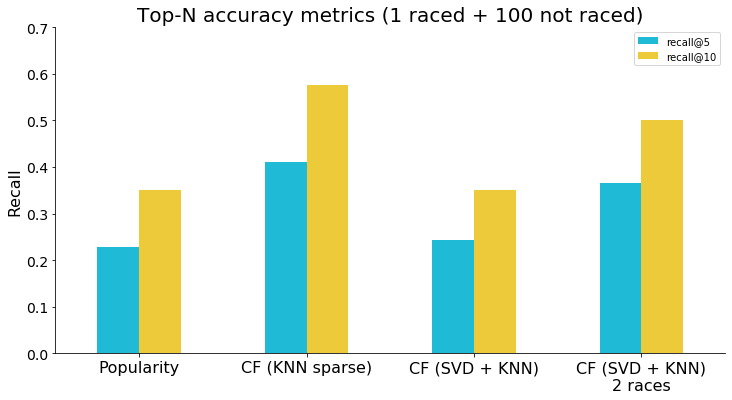

In [379]:
fig,ax = plt.subplots(figsize=(12, 6))

# ax.bar(np.arange(4), compare['recall@5'])

# ax.bar(np.arange(5, 9), compare['recall@10'])

compare.plot(kind='bar', ax=ax, color=['#1FBAD6', '#EDCA3A']) #FC4E07 #E7B800 #00AFBB #E7B800
ax.set_xticklabels(['Popularity', 'CF (KNN sparse)', 'CF (SVD + KNN)', 'CF (SVD + KNN)\n2 races'], rotation=0, size=16)
ax.set_yticks(np.arange(0, 0.71, 0.1))
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
ax.set_xlabel('')
ax.set_ylabel('Recall', size=16)

ax.set_title("Top-N accuracy metrics (1 raced + 100 not raced)", size=20)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
    
fig.savefig('figs/recall.pdf')

## Other way around

In [74]:
X = wide_race_data.values
X.shape

(153, 248360)

In [75]:
c

(153, 15)

We calculate the Pearson’s R correlation coefficient for every book pair in our final matrix. To compare this with the results from kNN, we pick the same book “The Green Mile: Coffey’s Hands (Green Mile Series)” to find the books that have high correlation coefficients (between 0.9 and 1.0) with it.

In [76]:
corr = np.corrcoef(matrix)
corr.shape

(153, 153)

In [89]:
corr_df = pd.DataFrame(corr, columns=race_ids, index=race_ids)

In [92]:
# corr_df['france70.3'].sort_values(ascending=False)

In [78]:
race_ids = wide_race_data.index
race_list = list(race_ids)

In [81]:
race_to_look = race_list.index('france70.3')
corr_race_to_look = corr[race_to_look]

In [ ]:
pd.DataFrame({'similarity': corr_race_to_look})

In [94]:
# [(corr_race_to_look<1) & (corr_race_to_look>0.9)]

In [100]:
# np.array(race_list)[(corr_race_to_look<1) & (corr_race_to_look>0.97)]

In [98]:
corr_df['france70.3'].sort_values(ascending=False)

race
france70.3                 1.000000
Nice70.3                   0.999631
vichy70.3                  0.998014
france                     0.994491
kronborg70.3               0.991059
vichy                      0.988667
Haugesund70.3              0.983067
switzerland70.3            0.978932
copenhagen                 0.977151
barcelona70.3              0.976647
mallorca70.3               0.975380
switzerland                0.969732
luxembourg70.3             0.964376
germany                    0.958834
marbella70.3               0.957054
finland70.3                0.955584
Maastricht                 0.952385
haugesund                  0.952308
otepaa70.3                 0.950615
kraichgau70.3              0.950190
lanzarote                  0.950017
tallinn                    0.946383
joenkoeping70.3            0.942900
barcelona                  0.939822
kalmar                     0.936384
lanzarote70.3              0.928173
ruegen70.3                 0.923308
hamburg                

In [117]:
X = wide_race_data.values

SVD = TruncatedSVD(n_components=15, random_state=17)
matrix = SVD.fit_transform(X)
matrix.shape

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(matrix)

# make sure the filtering df has the same data/order than the wide_race_data
df_to_filter_races = pd.DataFrame(list(wide_race_data.index.map(lambda x: race_filter.loc[x].to_dict())), index=wide_race_data.index)

def get_prediction_svd_fast(similarTo, n=10, filterBy=False, value=False):
    query_index = np.where(wide_race_data.index == similarTo)[0][0]
    total_n = wide_race_data.shape[0]
    distances, indices = model_knn.kneighbors(matrix[query_index].reshape(1, -1), n_neighbors = total_n)
    distances = distances.flatten()
    indices = indices.flatten()
    
    if filterBy:
        selection_idx = get_filtered_races(filterBy, value, df=df_to_filter_races, returnIndices=False)
        n = n if n<len(selection_idx) else len(selection_idx)
        out_indices = []
        out_distances = []
        
        for indice,distance in zip(indices, distances):
            if ((wide_race_data.index[indice] in selection_idx) and (wide_race_data.index[indice] != similarTo)):
                out_indices.append(indice)
                out_distances.append(distance)
                if len(out_distances) >=n :
                    break
    else:
        out_indices = indices
        out_distances = distances
    
    return [(wide_race_data.index[indice], distance) for indice,distance in zip(out_indices, out_distances)]